# Loading stuff

In [1]:
import os
import time
import hickle
from astropy.table import Table
from tqdm import tqdm

os.environ['SPS_HOME'] = '/arc/home/kartheikiyer/fsps/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dense_basis as db

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [3]:
from astropy.io import fits

# Defining the filter list

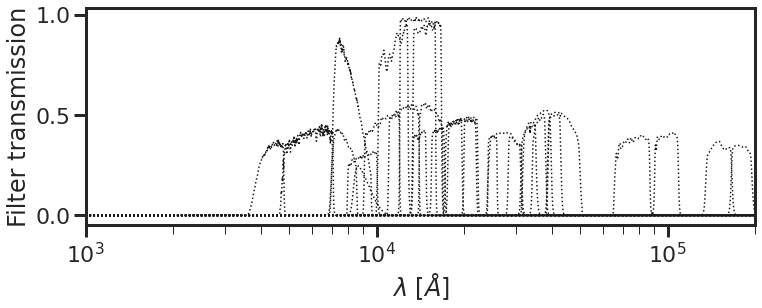

In [4]:
filter_list = 'hst_jwst_filters.dat'
filt_dir = '/arc/home/kartheikiyer/dense_basis_modeling/filter_curves/'
# filt_centers = [11391.33, 14846.46, 19626.21, 8986.46, 11434.99, 14873.38, 19680.88, 27279.54, 35287.43, 40723.09, 43504.40, 4331.36, 5777.15, 8035.76]

db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

filter_names = ['ACS_f435w', 'ACS_f606w', 'ACS_f775w', 'ACS_f814w', 'ACS_f850lp', 
                'WFC3_f105w', 'WFC3_f125w', 'WFC3_f140w', 'WFC3_f160w',
                'NIRCam.F090W','NIRISS.F115W','NIRISS.F150W','NIRCam.F200W',
                'NIRCam.F277W','NIRCam.F356W','NIRCam.F444W',
                'NIRCam.F140M','NIRCam.F162M','NIRCam.F182M','NIRCam.F210M','NIRCam.F250M',
                'NIRCam.F300M','NIRCam.F335M','NIRCam.F360M','NIRCam.F410M',
                'MIRI.F770W','MIRI.F1000W','MIRI.F1500W','MIRI.F1800W']

lam_centers = []
lam_widths = []

lam = np.linspace(1e3,1e6,int(1e5))
z = 0.0
vb = False

fcurves = db.make_filvalkit_simple(lam,z, fkit_name = filter_list ,vb=False, filt_dir = filt_dir)

for i in range(fcurves[0].shape[1]):

    normed_fc = np.cumsum(fcurves[0].T[i])/np.amax(np.cumsum(fcurves[0].T[i]))
    lam_eff = fcurves[1][np.argmin(np.abs(normed_fc-0.5))]
    lam_width_lo = fcurves[1][np.argmin(np.abs(normed_fc-0.025))]
    lam_width_hi = fcurves[1][np.argmin(np.abs(normed_fc-0.975))]
    lam_width = lam_width_hi - lam_width_lo

    lam_centers.append(lam_eff)
    lam_widths.append(lam_width)
    if vb == True:
        print(lam_eff, lam_width)
        print(filter_names[i])
        plt.plot(fcurves[1], normed_fc)
        plt.xscale('log')
        plt.show()
        
lam_centers = np.array(lam_centers)
lam_widths = np.array(lam_widths)

# Defining the filter list and getting the PHOTFLAM/PHOTFNU values

In [5]:
sparkle_dir = '/arc/projects/canucs/cutouts/sparkly_sparkler_kartheik/'

filt_names = np.array(['f090w', 'f150w', 'f200w', 'f277w', 'f356w', 'f435w',
       'f444w', 'f606w', 'f814w'], dtype='<U5')
filt_names

array(['f090w', 'f150w', 'f200w', 'f277w', 'f356w', 'f435w', 'f444w',
       'f606w', 'f814w'], dtype='<U5')

In [6]:
def flam_to_ujy(flam,lam):
    ujy = ((flam*1e-19) * ((lam**2.)*(1e6))) / (3e-5)
    return ujy

photfnu_values = np.zeros((len(filt_names),))
photflam_values = np.zeros((len(filt_names),))

units_dir = '/arc/projects/canucs/smacs0723/images/'

c = 2.99792458e10 #cm/s

for i in range(len(filt_names)):

    try:
        print('Filter:', filt_names[i])
        print('Filename:',sparkle_dir+'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits')
        print('Header photfnu:', fits.open(sparkle_dir+'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits')[0].header['PHOTFNU'])
        photfnu_values[i] = fits.open(sparkle_dir+'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits')[0].header['PHOTFNU'] 
        temp1 = fits.open(sparkle_dir+'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits')[0].header['PHOTFNU']
        temp2 = fits.open(sparkle_dir+'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits')[0].header['PHOTFLAM']
        
        print('Header photfnu vs converted photflam comparison:', temp1, flam_to_ujy(temp2,lam_centers[i])*1e14)
        # print(i, temp1,temp2)
    except:
        try:
            print('Header photflam:', fits.open(sparkle_dir+'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits')[0].header['PHOTFLAM'])
            photflam_values[i] = fits.open(sparkle_dir+'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits')[0].header['PHOTFLAM']
            for j, fn in enumerate(filter_names):
                if (filt_names[i].lower() in fn.lower()):
                    print(filt_names[i], fn)
                    temp = flam_to_ujy(photflam_values[i], lam_centers[j])*1e14
                    photfnu_values[i] = temp
                    
        except:
            try:
                temp2 = fits.open(units_dir+'smacs0723-'+filt_names[i]+'_drz_sci_20mas.fits')[0].header['PHOTFNU']
                photfnu_values[i] = temp2 * 4
                print('multiploed by fore')
                print(temp2)
            except:
                print('no photfnu or photflam for this filter')
    print('------')

Filter: f090w
Filename: /arc/projects/canucs/cutouts/sparkly_sparkler_kartheik/sparkly_sparkler-f090w_sci_40mas.fits
multiploed by fore
2.26938947174952e-08
------
Filter: f150w
Filename: /arc/projects/canucs/cutouts/sparkly_sparkler_kartheik/sparkly_sparkler-f150w_sci_40mas.fits
multiploed by fore
2.26938947174952e-08
------
Filter: f200w
Filename: /arc/projects/canucs/cutouts/sparkly_sparkler_kartheik/sparkly_sparkler-f200w_sci_40mas.fits
multiploed by fore
2.26938947174952e-08
------
Filter: f277w
Filename: /arc/projects/canucs/cutouts/sparkly_sparkler_kartheik/sparkly_sparkler-f277w_sci_40mas.fits
Header photfnu: 9.32193288268715e-08
Header photfnu vs converted photflam comparison: 9.32193288268715e-08 7.785250911059335e-08
------
Filter: f356w
Filename: /arc/projects/canucs/cutouts/sparkly_sparkler_kartheik/sparkly_sparkler-f356w_sci_40mas.fits
Header photfnu: 9.32193288268715e-08
Header photfnu vs converted photflam comparison: 9.32193288268715e-08 5.8740677740321536e-08
------
F

In [7]:
photfnu_values

array([9.07755789e-08, 9.07755789e-08, 9.07755789e-08, 9.32193288e-08,
       9.32193288e-08, 1.99829129e-06, 9.32193288e-08, 9.31794954e-07,
       1.50442812e-06])

# Building the SED datacube

In [8]:
sparkle_cube = []

for i in range(len(filt_names)):

    fname = 'sparkly_sparkler-'+filt_names[i]+'_sci_40mas.fits'
    temp = fits.open(sparkle_dir + fname)[0].data
    sparkle_cube.append(temp)
    print(fname)
    
sparkle_cube = np.array(sparkle_cube)
print(sparkle_cube.shape)

cat_seds = np.zeros((sparkle_cube.shape[1], sparkle_cube.shape[2], fcurves[0].shape[1]))
cat_errs = np.zeros((sparkle_cube.shape[1], sparkle_cube.shape[2], fcurves[0].shape[1]))

filt_mask = np.zeros((len(filter_names),))
for i, filt_name in enumerate(filt_names):

    for j, fn in enumerate(filter_names):
        if (filt_name.lower() in fn.lower()):# & ('NIRISS' not in fn):
            print(i,j, filt_name, fn)
            cat_seds[0:, 0:, j] = sparkle_cube[i, 0:, 0:] * photfnu_values[i] * 1e6
            filt_mask[j] = True
cat_errs = cat_seds*0.03

sparkly_sparkler-f090w_sci_40mas.fits
sparkly_sparkler-f150w_sci_40mas.fits
sparkly_sparkler-f200w_sci_40mas.fits
sparkly_sparkler-f277w_sci_40mas.fits
sparkly_sparkler-f356w_sci_40mas.fits
sparkly_sparkler-f435w_sci_40mas.fits
sparkly_sparkler-f444w_sci_40mas.fits
sparkly_sparkler-f606w_sci_40mas.fits
sparkly_sparkler-f814w_sci_40mas.fits
(9, 252, 252)
0 9 f090w NIRCam.F090W
1 11 f150w NIRISS.F150W
2 12 f200w NIRCam.F200W
3 13 f277w NIRCam.F277W
4 14 f356w NIRCam.F356W
5 0 f435w ACS_f435w
6 15 f444w NIRCam.F444W
7 1 f606w ACS_f606w
8 3 f814w ACS_f814w


# Checking the photometry to see if it makes sense

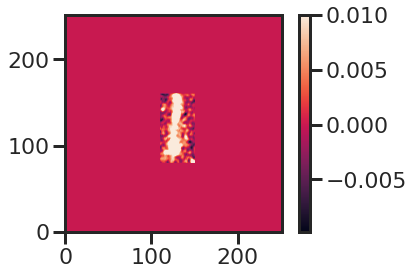

In [9]:
cat_seds_cutout = cat_seds.copy()
cat_seds_cutout[0:,0:55*2] = 0
cat_seds_cutout[0:,75*2:] = 0
cat_seds_cutout[0:40*2,0:] = 0
cat_seds_cutout[80*2:,0:] = 0

plt.imshow(cat_seds_cutout[0:,0:,0],vmax=1e-2,origin='lower')
plt.colorbar()
plt.show()

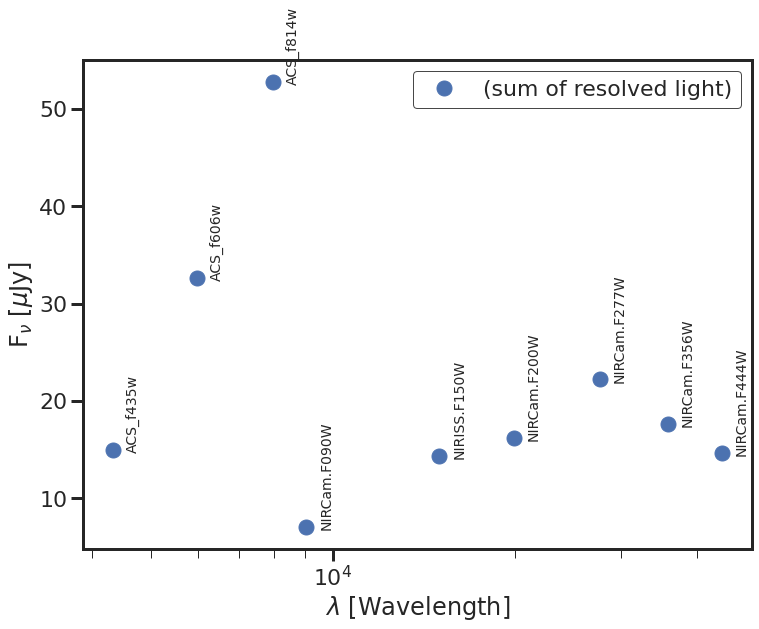

0 ACS_f435w 15.008564605289795
1 ACS_f606w 32.64319482843194
2 ACS_f775w 0.0
3 ACS_f814w 52.778648085593154
4 ACS_f850lp 0.0
5 WFC3_f105w 0.0
6 WFC3_f125w 0.0
7 WFC3_f140w 0.0
8 WFC3_f160w 0.0
9 NIRCam.F090W 7.08263052022462
10 NIRISS.F115W 0.0
11 NIRISS.F150W 14.326166122431609
12 NIRCam.F200W 16.21332407359621
13 NIRCam.F277W 22.228216548181585
14 NIRCam.F356W 17.68794160190657
15 NIRCam.F444W 14.70804422447263
16 NIRCam.F140M 0.0
17 NIRCam.F162M 0.0
18 NIRCam.F182M 0.0
19 NIRCam.F210M 0.0
20 NIRCam.F250M 0.0
21 NIRCam.F300M 0.0
22 NIRCam.F335M 0.0
23 NIRCam.F360M 0.0
24 NIRCam.F410M 0.0
25 MIRI.F770W 0.0
26 MIRI.F1000W 0.0
27 MIRI.F1500W 0.0
28 MIRI.F1800W 0.0


In [10]:
plt.figure(figsize=(12,9))
sumsed = np.sum(np.sum(cat_seds_cutout,0),0)
# plt.errorbar(lam_centers[mask1], integrated_sed_sparkly[mask1], yerr=integrated_err_sparkly[mask1],marker='o',lw=0,elinewidth=2,capsize=5,label='integrated_light')
mask2 = (sumsed>0)
plt.plot(lam_centers[mask2], sumsed[mask2],'o',markersize=15,label='(sum of resolved light)')
for i in range(len(filter_names)):
    if mask2[i] == True:
        plt.text(lam_centers[i]*1.05, sumsed[i], filter_names[i],rotation=90,fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\lambda$ [Wavelength]')
plt.ylabel(r'F$_\nu$ [$\mu$Jy]')
plt.legend(edgecolor='k')
# plt.yscale('log')
plt.savefig('integrated_phot_sparkles.png',bbox_inches='tight')
plt.show()

for i in range(len(filter_names)):
    print(i, filter_names[i], sumsed[i])

# It doesn't make sense

# Loading the priors and setting up the cube fitter

In [11]:
# Priors class, to see all the options look in the priors.py file in the dense_basis folder
priors = db.Priors()
priors.mass_min = 7.
priors.mass_max = 12.

# SFH priors
priors.Nparam = 3
priors.tx_alpha = np.ones((priors.Nparam+1,))*3.0

# SFR prior
priors.sfr_prior_type = 'sSFRflat'
priors.ssfr_max = -7.
priors.ssfr_min = -14.
priors.dynamic_decouple = False

# metallicity prior
priors.met_treatment = 'flat'
priors.Z_min = -1.5
priors.Z_max = 0.25

# dust prior
priors.dust_prior = 'exp'
priors.Av_min = 0
priors.Av_max = 4 

# redshift prior

zval = 1.3779
dz = 0.16

priors.z_min = zval-dz
priors.z_max = zval+dz

N_pregrid = 100000
path=''

fname = "atlas_chunks_sparkles"


try:
    atlas = db.load_atlas(fname, N_pregrid, priors.Nparam, path=path)
    
except:

    db.generate_atlas(N_pregrid = N_pregrid,
                      priors = priors,
                      fname = fname, store=True, path=path,
                      filter_list = filter_list, filt_dir = filt_dir)

    atlas = db.load_atlas(fname, N_pregrid, priors.Nparam, path=path)

In [12]:
# use this code if using the atlas_chunks_combined large atlas to reduce fitting times.

# zmask = (np.abs(atlas['zval'] - zval) < dz)
# np.sum(zmask)

# small_atlas = atlas.copy()

# for i in small_atlas.keys():
#     try:
#         # print(small_atlas[i].shape)
#         shapetuple = small_atlas[i].shape
#         if len(shapetuple) == 1:
#             small_atlas[i] = small_atlas[i][zmask.ravel()]
#         elif shapetuple[1] == 0:
#             small_atlas[i] = small_atlas[i][zmask.ravel(),0]
#         else:
#             small_atlas[i] = small_atlas[i][zmask.ravel(),0:]
#         # print(small_atlas[i].shape)
#     except:
#         print(i,':', small_atlas[i])

small_atlas = atlas

def fit_cube(cat_sed, cat_err, zval, dz, fit_atlas):
    
    tuniv = db.cosmo.age(zval).value
    
    cube_mass = np.zeros((cat_sed.shape[0], cat_sed.shape[1], 3))
    cube_sfr = np.zeros((cat_sed.shape[0], cat_sed.shape[1], 3))
    cube_met = np.zeros((cat_sed.shape[0], cat_sed.shape[1], 3))
    cube_dust = np.zeros((cat_sed.shape[0], cat_sed.shape[1], 3))
    cube_t25 = np.zeros((cat_sed.shape[0], cat_sed.shape[1], 3))
    cube_t50 = np.zeros((cat_sed.shape[0], cat_sed.shape[1], 3))
    cube_t75 = np.zeros((cat_sed.shape[0], cat_sed.shape[1], 3))
    cube_chi2 = np.zeros((cat_sed.shape[0], cat_sed.shape[1]))
    
    print(cat_sed.shape)
    for xi in db.tqdm(range(cat_sed.shape[0])):
        for yj in range(cat_sed.shape[1]):
            
            sed = cat_sed[xi,yj,0:]
            err = cat_err[xi,yj,0:]
            
            sedfit = db.SedFit(sed, err, fit_atlas, fit_mask = filt_mask.astype(bool), zbest = zval, deltaz= dz)
            sedfit.evaluate_likelihood()
            sedfit.evaluate_posterior_percentiles()

            cube_mass[xi,yj,0:] = sedfit.mstar
            cube_sfr[xi,yj,0:] = sedfit.sfr
            cube_dust[xi,yj,0:] = sedfit.Av
            cube_met[xi,yj,0:] = sedfit.Z
            cube_t25[xi,yj,0:] = sedfit.sfh_tuple[0:,3] * tuniv
            cube_t50[xi,yj,0:] = sedfit.sfh_tuple[0:,4] * tuniv
            cube_t75[xi,yj,0:] = sedfit.sfh_tuple[0:,5] * tuniv
            cube_chi2[xi,yj] = np.amin(sedfit.chi2_array)
            
        cube_data = [cat_sed, cat_err, zval, dz, cube_mass, cube_sfr, cube_dust, cube_met, cube_t25, cube_t50, cube_t75, cube_chi2]
        hickle.dump(cube_data, 'sparkly_cube_fits_recalibrated_19july22.h5')
        
    cube_data = [cat_sed, cat_err, zval, dz, cube_mass, cube_sfr, cube_dust, cube_met, cube_t25, cube_t50, cube_t75, cube_chi2]
    hickle.dump(cube_data, 'sparkly_cube_fits_recalibrated_19july22.h5')

    return cube_data   

In [ ]:
# cube_data = fit_cube(cat_seds_recal, cat_seds_recal*0.03, zval, dz, small_atlas)

In [ ]:
# [cat_sed, cat_err, zval, dz, cube_mass, cube_sfr, cube_dust, cube_met, cube_t25, cube_t50, cube_t75, cube_chi2] = cube_data

# visualising stuff

In [13]:
import scipy as sp
import scipy.ndimage

In [14]:
mag = 15.357

cut1 = 30
cut2 = -10
cut3 = 10
cut4 = -10

mass_map = (10**cube_mass[0:,0:,0])/mag
# mass_map = 10**cube_mass[0:,0:,0]/mag
mass_map[np.isnan(mass_map)] = 0.0

sfr_map = (10**cube_sfr[0:,0:,0])/mag
# mass_map = 10**cube_mass[0:,0:,0]/mag
sfr_map[np.isnan(sfr_map)] = 0.0

t50_map = cube_t50[0:,0:,0]
# mass_map = 10**cube_mass[0:,0:,0]/mag
t50_map[np.isnan(t50_map)] = 0.0

dust_map = cube_dust[0:,0:,0]
# mass_map = 10**cube_mass[0:,0:,0]/mag
dust_map[np.isnan(dust_map)] = 0.0

met_map = cube_met[0:,0:,0]
# mass_map = 10**cube_mass[0:,0:,0]/mag
met_map[np.isnan(met_map)] = 0.0

# ------- map smoothing

sigma = 0.0
sigma = [sigma, sigma]
mass_map = sp.ndimage.filters.gaussian_filter(mass_map, sigma, mode='constant')
sfr_map = sp.ndimage.filters.gaussian_filter(sfr_map, sigma, mode='constant')
t50_map = sp.ndimage.filters.gaussian_filter(t50_map, sigma, mode='constant')


plt.figure(figsize=(14,9))
plt.imshow(t50_map[cut1:cut2,cut3:cut4],origin='lower',cmap='tab10',vmin=0., vmax = db.cosmo.age(zval).value, 
           alpha=mass_map[cut1:cut2,cut3:cut4]/1.15/np.amax(1.2e6))
# plt.imshow(t50_map,origin='lower',cmap='tab10',vmin=0., vmax = db.cosmo.age(zval).value)
# plt.imshow(mass_map,origin='lower', vmin=0, vmax = 1.2e6,alpha=0.7,cmap='gray')
clbr = plt.colorbar()
clbr.set_label('t$_{50}$ [Gyr]')
# print(clbr.get_ticks())
plt.xticks([]); plt.yticks([])
plt.show()

plt.figure(figsize=(14,9))
plt.imshow(mass_map[cut1:cut2,cut3:cut4],origin='lower', vmin=0, vmax = 1.2e6)
clbr = plt.colorbar()
clbr.set_label('Stellar Mass [M$_\odot$]')
# print(clbr.get_ticks())
plt.xticks([]); plt.yticks([])
plt.show()

plt.figure(figsize=(14,9))
plt.imshow(sfr_map[cut1:cut2,cut3:cut4],origin='lower',vmin=0., vmax = 1e-3)
clbr = plt.colorbar()
clbr.set_label('SFR [M$_\odot$/yr]')
# print(clbr.get_ticks())
plt.xticks([]); plt.yticks([])
plt.show()


NameError: name 'cube_mass' is not defined

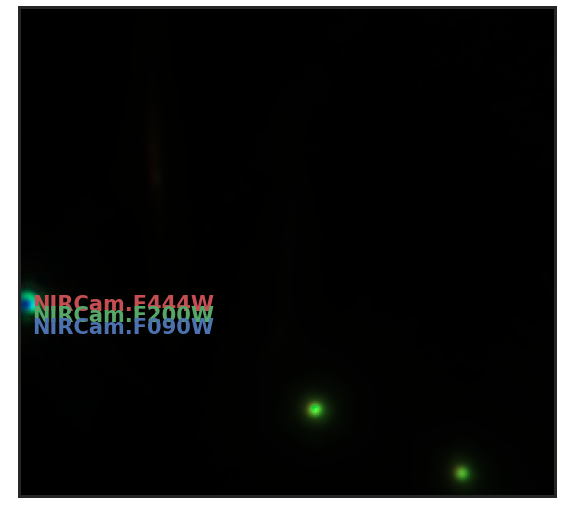

In [15]:
plt.figure(figsize=(10.5,9))

temp = (cat_seds)[cut1:cut2, cut3:cut4,filt_mask.astype(bool)][0:,0:,np.array([8,5,3])]
temp = temp-np.nanmin(temp)
temp = temp/np.nanmax(temp)
plt.imshow(temp,origin='lower')
plt.xticks([]);plt.yticks([])
plt.text(5,80,np.array(filter_names)[filt_mask.astype(bool)][8],
         fontsize=21,fontweight='bold',color='r')
plt.text(5,75,np.array(filter_names)[filt_mask.astype(bool)][5],
         fontsize=21,fontweight='bold',color='g')
plt.text(5,70,np.array(filter_names)[filt_mask.astype(bool)][3],
         fontsize=21,fontweight='bold',color='b')
plt.show()

# Fits to specific parts of the image

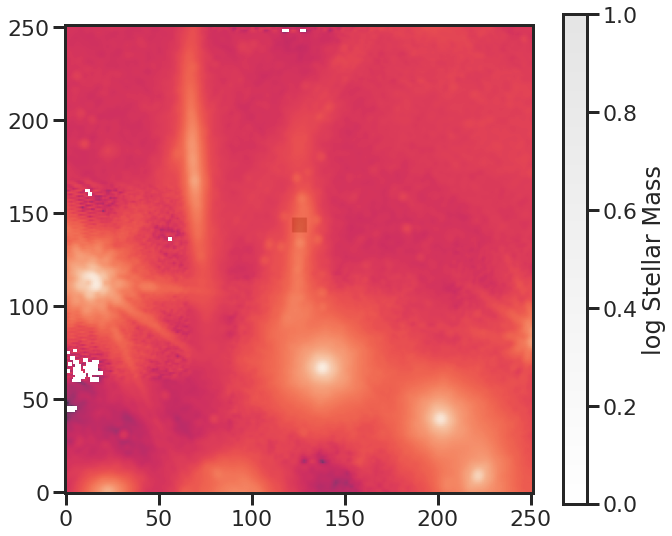

# filters:  9


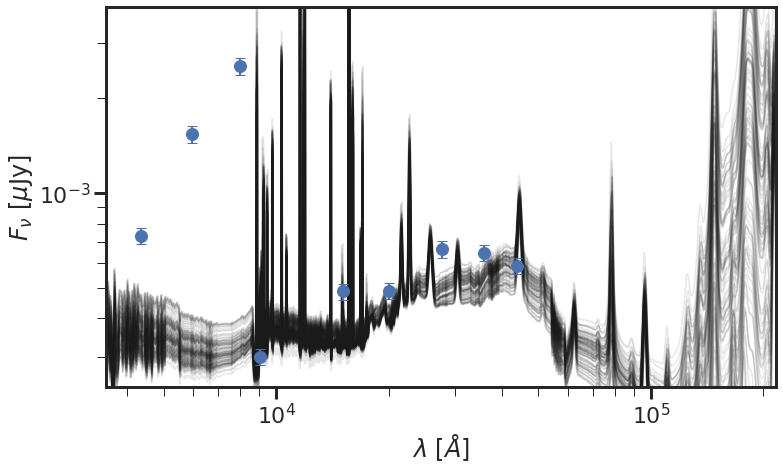

couldnt set axis limits


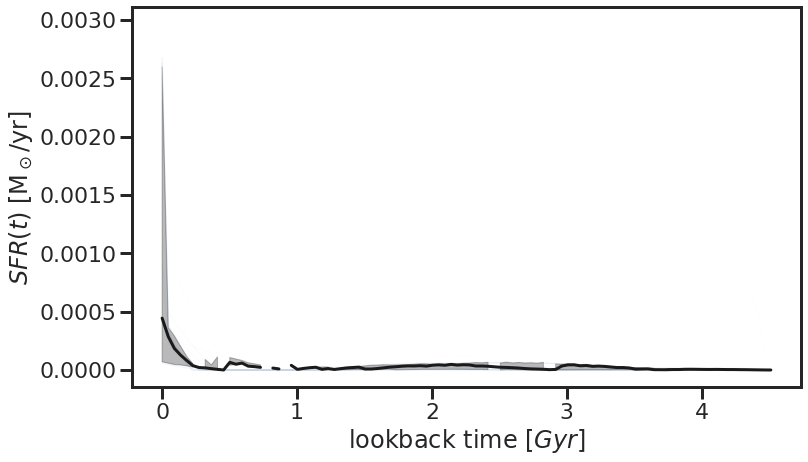

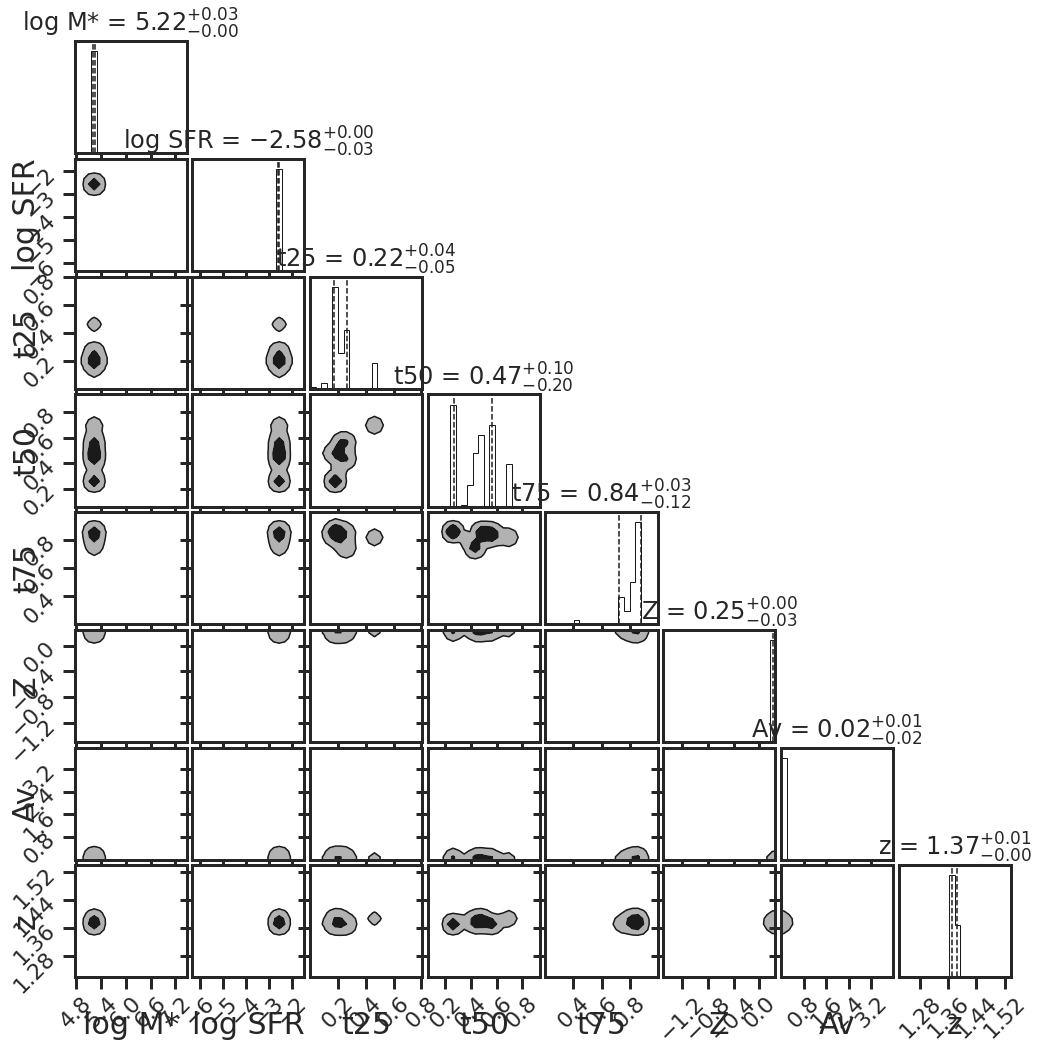

In [16]:
plt.figure(figsize=(10.5,9))
plt.imshow(np.log10(cat_seds)[0:,0:,filt_mask.astype(bool)][0:,0:,5],origin='lower')

tempmask = np.zeros_like(cat_seds[0:,0:,0])
xorig = 72*2
yorig = 63*2
xlim = 4
ylim = 4

tempmask[(xorig-xlim):(xorig+xlim), (yorig-ylim):(yorig+ylim)] = 1.0

plt.imshow(tempmask, cmap='gray_r',alpha=0.1,origin='lower')
clbr = plt.colorbar()
clbr.set_label('log Stellar Mass')
plt.show()

# int_sed = cat_seds[(xorig-xlim):(xorig+xlim), (yorig-ylim):(yorig+ylim),0:]
# int_sed = np.sum(np.sum(int_sed,0),0) / mag
int_sed = cat_seds[xorig, yorig, 0:] / mag
int_err = int_sed*0.03 

# --------------- fitting the SED ------------------

sedfit = db.SedFit(int_sed, int_err, small_atlas, fit_mask = filt_mask.astype(bool), zbest = zval, deltaz= 0.01)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

# --------------- plotting results ----------------

print('# filters: ', np.sum(filt_mask.astype(bool)))
sedfit.plot_posterior_spec(filt_centers=lam_centers, priors = priors, fnu = True)
# plt.title('Galaxy ID: %.0f, eazy_z500: %.2f$\pm$%.2f ($\chi^2_{bf} = %.2f$)' %(gal_id, eazy_z, eazy_zw, np.nanmin(sedfit.chi2_array)))
# plt.ylim(np.amin(sed[fit_mask])/1.4, np.amax(sed[fit_mask])*1.4)
plt.show()

sedfit.plot_posterior_SFH(zval = zval)
# plt.title('Galaxy ID: %.0f, eazy_z$_{50}$: %.2f$\pm$%.2f' %(gal_id, eazy_z, eazy_zw))
plt.show()

sedfit.plot_posteriors()
plt.gcf().set_size_inches(9,9)
plt.show()